 # 使用神经网络对手写数字进行分类
 
  ![img](https://www.tensorflow.org/versions/r0.11/images/MNIST.png)
 
 **学习目标：**
  * 训练线性模型和神经网络，以对传统 [MNIST](http://yann.lecun.com/exdb/mnist/) 数据集中的手写数字进行分类
  * 比较线性分类模型和神经网络分类模型的效果
  * 可视化神经网络隐藏层的权重

# 设置

In [3]:
import glob
import io
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

mnist_dataframe = pd.read_csv(
  io.open("mnist_train_small.csv", "r"),
  sep=",",
  header=None)

# Use just the first 10,000 records for training/validation
mnist_dataframe = mnist_dataframe.head(10000)

mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
mnist_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
3623,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9275,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6281,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5149,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1943,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 第一列中包含类别标签。其余列中包含特征值，每个像素对应一个特征值，有 `28×28=784` 个像素值，其中大部分像素值都为零
 
  ![img](https://www.tensorflow.org/versions/r0.11/images/MNIST-Matrix.png)
  
 这些样本都是分辨率相对较低、对比度相对较高的手写数字图片。0-9 这十个数字中的每个可能出现的数字均由唯一的类别标签表示。因此，这是一个具有 10 个类别的多类别分类问题。

现在，我们解析一下标签和特征，并查看几个样本。注意 loc 的使用，借助 loc，我们能够基于原来的位置抽出各列，因为此数据集中没有标题行。

In [4]:
def parse_labels_and_features(dataset):
    labels = dataset[0]
    features = dataset.loc[:,1:784]
    features = features / 255
    return labels, features

In [5]:
training_targets, training_examples = parse_labels_and_features(mnist_dataframe[:7500])
training_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.8,0.2,1.0,0.2,0.0,0.0,0.0,0.0


In [6]:
validation_targets, validation_examples = parse_labels_and_features(mnist_dataframe[7500:10000])
validation_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,...,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


显示一个随机样本及其对应的标签。

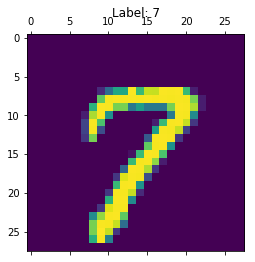

In [7]:
%matplotlib inline
rand_example = np.random.choice(training_examples.index)
_, ax = plt.subplots()
ax.matshow(training_examples.loc[rand_example].values.reshape(28, 28))
ax.set_title("Label: %i" % training_targets.loc[rand_example])
ax.grid(False)

## 为MNIST构建线性模型

首先，我们创建一个基准模型，作为比较对象。`LinearClassifier` 可提供一组 *k* 类一对多分类器，每个类别（共 *k* 个）对应一个分类器。

我们会发现，除了报告准确率和绘制对数损失函数随时间变化情况的曲线图之外，我们还展示了一个[**混淆矩阵**](https://en.wikipedia.org/wiki/Confusion_matrix)。混淆矩阵会显示错误分类为其他类别的类别。哪些数字相互之间容易混淆？

另请注意，我们会使用 `log_loss` 函数跟踪模型的错误。不应将此函数与用于训练的 `LinearClassifier` 内部损失函数相混淆。

In [8]:
def construct_feature_columns():
    return set([tf.feature_column.numeric_column('pixels', shape=784)])

 在本次练习中，我们会对训练和预测使用单独的输入函数，并将这些函数分别嵌套在 `create_training_input_fn()` 和 `create_predict_input_fn()` 中，这样一来，我们就可以调用这些函数，以返回相应的 `_input_fn`，并将其传递到 `.train()` 和 `.predict()` 调用。

In [9]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
    
    def _input_fn(num_epoch=None, shuffle=True):
        idx = np.random.permutation(features.index)
        raw_features = {"pixels": features.reindex(idx)}
        raw_targets = np.array(labels[idx])
        
        ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
        ds = ds.batch(batch_size).repeat(num_epochs)

        if shuffle:
            ds = ds.shuffle(10000)

        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch

    return _input_fn

In [12]:
def create_predict_input_fn(features, labels, batch_size):

    def _input_fn():
        raw_features = {"pixels": features.values}
        raw_targets = np.array(labels)

        ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
        ds = ds.batch(batch_size)

        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch

    return _input_fn

In [13]:
def train_linear_classification_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

    periods = 10

    steps_per_period = steps / periods  
    # Create the input functions.
    predict_training_input_fn = create_predict_input_fn(
        training_examples, training_targets, batch_size)
    predict_validation_input_fn = create_predict_input_fn(
        validation_examples, validation_targets, batch_size)
    training_input_fn = create_training_input_fn(
        training_examples, training_targets, batch_size)

    # Create a LinearClassifier object.
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.LinearClassifier(
        feature_columns=construct_feature_columns(),
        n_classes=10,
        optimizer=my_optimizer,
        config=tf.estimator.RunConfig(keep_checkpoint_max=1)
    )

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )

        # Take a break and compute probabilities.
        training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)

        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)    

        # Compute training and validation errors.
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model training finished.")
    # Remove event files to save disk space.
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    # Calculate final predictions (not probabilities, as above).
    final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])


    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()

    # Output a plot of the confusion matrix.
    cm = metrics.confusion_matrix(validation_targets, final_predictions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return classifier

Training model...
LogLoss error (on validation data):
  period 00 : 19.84
  period 01 : 11.52
  period 02 : 10.11
  period 03 : 7.46
  period 04 : 6.98
  period 05 : 8.50
  period 06 : 7.74
  period 07 : 5.75
  period 08 : 5.66
  period 09 : 5.48
Model training finished.
Final accuracy (on validation data): 0.84


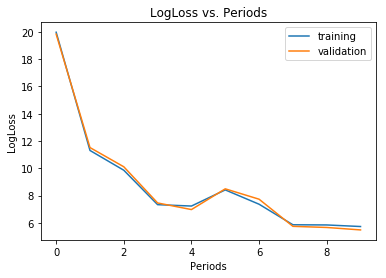

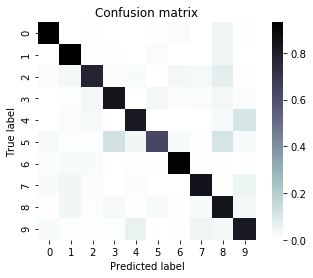

In [14]:
classifier = train_linear_classification_model(
             learning_rate=0.02,
             steps=100,
             batch_size=10,
             training_examples=training_examples,
             training_targets=training_targets,
             validation_examples=validation_examples,
             validation_targets=validation_targets)

Training model...
LogLoss error (on validation data):
  period 00 : 4.20
  period 01 : 3.95
  period 02 : 3.66
  period 03 : 3.36
  period 04 : 3.63
  period 05 : 3.48
  period 06 : 3.45
  period 07 : 3.45
  period 08 : 3.36
  period 09 : 3.32
Model training finished.
Final accuracy (on validation data): 0.90


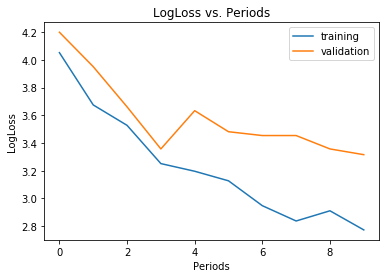

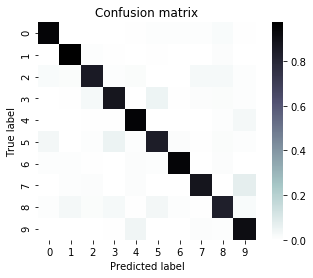

In [16]:
classifier = train_linear_classification_model(
             learning_rate=0.03,
             steps=1000,
             batch_size=30,
             training_examples=training_examples,
             training_targets=training_targets,
             validation_examples=validation_examples,
             validation_targets=validation_targets)

## 使用神经网络替换线性分类器

**使用 [`DNNClassifier`](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNClassifier) 替换上面的 LinearClassifier，并查找可实现 0.95 或更高准确率的参数组合。**

In [17]:
def train_nn_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

    periods = 10
    steps_per_period = steps / periods  
    # Create the input functions.
    predict_training_input_fn = create_predict_input_fn(
        training_examples, training_targets, batch_size)
    predict_validation_input_fn = create_predict_input_fn(
        validation_examples, validation_targets, batch_size)
    training_input_fn = create_training_input_fn(
        training_examples, training_targets, batch_size)

    # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column('pixels', shape=784)]

    # Create a DNNClassifier object.
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.DNNClassifier(
        feature_columns=feature_columns,
        n_classes=10,
        hidden_units=hidden_units,
        optimizer=my_optimizer,
        config=tf.contrib.learn.RunConfig(keep_checkpoint_max=1)
    )

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )

        # Take a break and compute probabilities.
        training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)

        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)    

        # Compute training and validation errors.
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model training finished.")
        
    # Remove event files to save disk space.
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    # Calculate final predictions (not probabilities, as above).
    final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])


    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()

    # Output a plot of the confusion matrix.
    cm = metrics.confusion_matrix(validation_targets, final_predictions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return classifier

Training model...
LogLoss error (on validation data):
  period 00 : 4.43
  period 01 : 3.54
  period 02 : 2.58
  period 03 : 2.49
  period 04 : 2.53
  period 05 : 2.18
  period 06 : 2.38
  period 07 : 2.20
  period 08 : 2.04
  period 09 : 1.87
Model training finished.
Final accuracy (on validation data): 0.95


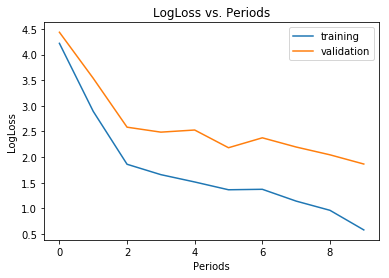

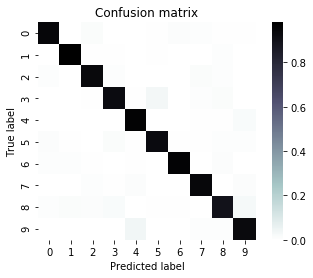

In [18]:
classifier = train_nn_classification_model(
    learning_rate=0.05,
    steps=1000,
    batch_size=30,
    hidden_units=[100, 100],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

验证测试集的准确率

In [19]:
mnist_test_dataframe = pd.read_csv(
    io.open("mnist_test.csv", "r"),
    sep=",",
header=None)

test_targets, test_examples = parse_labels_and_features(mnist_test_dataframe)
test_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
predict_test_input_fn = create_predict_input_fn(
    test_examples, test_targets, batch_size=100)

test_predictions = classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])
  
accuracy = metrics.accuracy_score(test_targets, test_predictions)
print("Accuracy on test data: %0.2f" % accuracy )

Accuracy on test data: 0.95


 ## 可视化第一个隐藏层的权重。

我们来花几分钟时间看看模型的 `weights_` 属性，以深入探索我们的神经网络，并了解它学到了哪些规律。

模型的输入层有 `784` 个权重，对应于 `28×28` 像素输入图片。第一个隐藏层将有 `784×N` 个权重，其中 `N` 指的是该层中的节点数。我们可以将这些权重重新变回 `28×28` 像素的图片，具体方法是将 `N` 个 `1×784` 权重数组*变形*为 `N` 个 `28×28` 大小数组。

运行以下单元格，绘制权重曲线图。请注意，此单元格要求名为 "classifier" 的 `DNNClassifier` 已经过训练。

['dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adagrad', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adagrad', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adagrad', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adagrad', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adagrad', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adagrad', 'global_step']
weights0 shape: (784, 100)


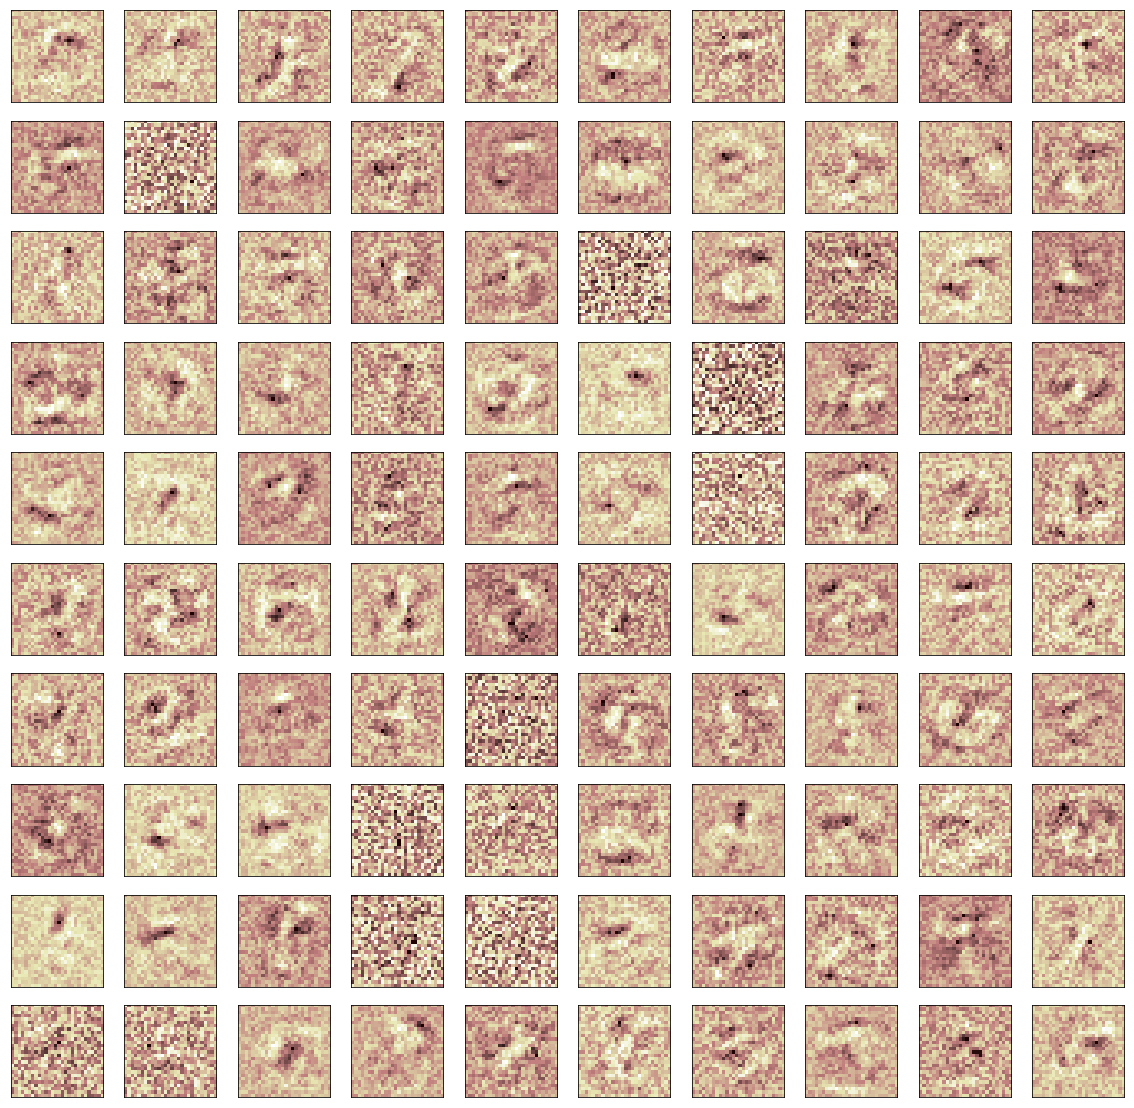

In [22]:
print(classifier.get_variable_names())

weights0 = classifier.get_variable_value("dnn/hiddenlayer_0/kernel")

print("weights0 shape:", weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(20, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.pink)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()